In [37]:
import os, os.path
import ogr, osr
import time
import os,os.path
import sys
import json

import numpy as np
import pandas as pd
import geopandas as gpd

import os, os.path
import urllib
import fiona
import google_streetview.api

from PIL import Image
from matplotlib import pyplot as plt
import requests
import io

## 1. Input Urban Mind data

In [2]:
synthetic = pd.read_csv('D:/NatCap Research/Wellcome Trust/synthetic data.csv')

In [3]:
synthetic.head()

,newid,assessmentnumber,umversion,participantid,participanttag,assessmentname,imageurl,audiourl,startlocationid,startlatitude,...,education_n,occupation_n,selfdiag_n,depressionvscontrol_n,depression_tables,fam_diagnosis,familydepressionvscontrol,number,totalnaturescore,naturalspaces
0,68,0,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,NaN,...,University,Student,No,No,0,No,No,38,NaN,NaN
1,68,1,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,NaN,...,University,Student,No,No,0,No,No,38,1.0,0.0
2,68,2,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,NaN,...,University,Student,No,No,0,No,No,38,2.0,0.0
3,68,3,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,NaN,...,University,Student,No,No,0,No,No,38,2.0,0.0
4,68,4,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,NaN,...,University,Student,No,No,0,No,No,38,3.0,0.0


### 1.1 Access geolocation information

In [4]:
synthetic['startlatitude'].fillna(synthetic['StartLatitude'], inplace=True)
synthetic['startlongitude'].fillna(synthetic['StartLongitude'], inplace=True)
synthetic.head()

,newid,assessmentnumber,umversion,participantid,participanttag,assessmentname,imageurl,audiourl,startlocationid,startlatitude,...,education_n,occupation_n,selfdiag_n,depressionvscontrol_n,depression_tables,fam_diagnosis,familydepressionvscontrol,number,totalnaturescore,naturalspaces
0,68,0,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,40.387798,...,University,Student,No,No,0,No,No,38,NaN,NaN
1,68,1,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,40.427101,...,University,Student,No,No,0,No,No,38,1.0,0.0
2,68,2,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,40.388401,...,University,Student,No,No,0,No,No,38,2.0,0.0
3,68,3,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,40.388699,...,University,Student,No,No,0,No,No,38,2.0,0.0
4,68,4,NaN,022b9a0c50df67849e91d5897aabbf39,NaN,NaN,NaN,NaN,NaN,40.426300,...,University,Student,No,No,0,No,No,38,3.0,0.0


In [5]:
df = synthetic[['participantid','assessmentnumber','startlatitude','startlongitude']]

In [6]:
df=df.loc[~((df['startlatitude']==0) | (df['startlongitude']==0))]

In [7]:
df = df[df['startlatitude'].notnull()]

In [15]:
df.head()

,participantid,assessmentnumber,startlatitude,startlongitude
0,022b9a0c50df67849e91d5897aabbf39,0,40.387798,-3.73564
1,022b9a0c50df67849e91d5897aabbf39,1,40.427101,-3.71367
2,022b9a0c50df67849e91d5897aabbf39,2,40.388401,-3.73194
3,022b9a0c50df67849e91d5897aabbf39,3,40.388699,-3.73668
4,022b9a0c50df67849e91d5897aabbf39,4,40.426300,-3.71645


## 2. Get metadata for GoogleStreetView image based on geolocation

In [16]:
c = df.reset_index(drop=True)[['participantid','assessmentnumber','startlatitude','startlongitude']].values.tolist()

In [17]:
outdir='D:/NatCap Research/Wellcome Trust/metadata'
key='' # Input your Google API key here
num=100 # the batch size

In [18]:
featureNum = len(c)
batch = int(featureNum/num + 0.5)

In [19]:
for b in range(batch):
    # for each batch process num GSV site
    start = b*num
    end = (b+1)*num
    if end > featureNum:
        end = featureNum
    
    ouputTextFile = 'Pnt_start%s_end%s.txt'%(start,end)
    ouputGSVinfoFile = os.path.join(outdir,ouputTextFile)
    
    if os.path.exists(ouputGSVinfoFile):
        continue

    time.sleep(1)
    
    with open(ouputGSVinfoFile, 'w') as panoInfoText:
        
        for i in c:
            user_id = i[0]
            assessment_time = i[1]
            lat = i[2]
            lon = i[3]
            print(user_id, assessment_time, lat, lon)
            urlAddress = r'https://maps.googleapis.com/maps/api/streetview/metadata?size=600x300&location=%s,%s&heading=-45&pitch=42&fov=110&key=%s'%(lat, lon, key)
            time.sleep(0.1)
            if sys.version_info[0] == 2:
                # from urllib2 import urlopen
                import urllib
                metaData = urllib.urlopen(urlAddress).read()

            if sys.version_info[0] == 3:
                import urllib.request
                request = urllib.request.Request(urlAddress)
                metaData = urllib.request.urlopen(request).read()

            data = json.loads(metaData)
            if data['status'] == 'NOT_FOUND': 
                print('The data is not existing')
                continue
            
            if data['status'] == 'ZERO_RESULTS': 
                print('The data is not existing')
                continue

            panoDate = data['date']
            panoId = data['pano_id']
            panoLat = data['location']['lat']
            panoLon = data['location']['lng']

            print ('User ID: %s, assessment time: %s, the coordinate (%s,%s), panoId is: %s, panoDate is: %s'%(user_id, assessment_time, panoLat,panoLon,panoId, panoDate))
            lineTxt = 'userID: %s assessment: %s panoID: %s panoDate: %s longitude: %s latitude: %s\n'%(user_id, assessment_time, panoId, panoDate, panoLon, panoLat)
            panoInfoText.write(lineTxt)
            
    panoInfoText.close()
    

022b9a0c50df67849e91d5897aabbf39 0 40.387798 -3.73564
User ID: 022b9a0c50df67849e91d5897aabbf39, assessment time: 0, the coordinate (40.38795474500751,-3.735863656054512), panoId is: lpqkB8z60fNtWGP89zkyvQ, panoDate is: 2024-01
022b9a0c50df67849e91d5897aabbf39 1 40.427101 -3.71367
User ID: 022b9a0c50df67849e91d5897aabbf39, assessment time: 1, the coordinate (40.42705101164147,-3.713672449213664), panoId is: vJJX_zUPf80qDj0kXhZ8jA, panoDate is: 2024-05
022b9a0c50df67849e91d5897aabbf39 2 40.388401 -3.73194
User ID: 022b9a0c50df67849e91d5897aabbf39, assessment time: 2, the coordinate (40.3883840837407,-3.731957463679926), panoId is: 6MQUnTZpaXkx-nP5VBL8iA, panoDate is: 2024-05
022b9a0c50df67849e91d5897aabbf39 3 40.388699 -3.73668
User ID: 022b9a0c50df67849e91d5897aabbf39, assessment time: 3, the coordinate (40.38864192835491,-3.736657853565247), panoId is: gSW81fn7PCdC6PB3w93Bew, panoDate is: 2023-12
022b9a0c50df67849e91d5897aabbf39 4 40.4263 -3.71645
User ID: 022b9a0c50df67849e91d5897aab

In [43]:
df.to_csv('D:/NatCap Research/Welcome Trust/test.csv', index=False)

# 3. Download GSV image 

In [30]:
root = 'D:/NatCap Research/Wellcome Trust/test'

In [31]:
indir= os.path.join(root, 'metadata_test')
outdir = os.path.join(root, 'gsvimgs')

In [38]:
if not os.path.exists(outdir):
    os.mkdir(outdir)

# list all the metadata and then get the lon, lat, date info to download the GSV images to your google drive
for txt in os.listdir(indir):
    txtfile = os.path.join(indir, txt)
    lines = open(txtfile,"r")
    pitch = 0

    # loop all lines in the txt files
    for idx,line in enumerate(lines):
        metadata = line.split(" ")
        userID = metadata[1]
        assessment = metadata[3]
        panoID = metadata[5]
        panoDate = metadata[7]
        month = panoDate[-2:]
        lon = metadata[9]
        lat = metadata[11][:-1]

        print('The lon, lat are:', lon, lat)

        headingArr = 360/6*np.array([0,1,2,3,4,5])

        # calculate the green view index
        greenPercent = 0.0

        for heading in headingArr:
            print ("Heading is: ",heading)

            # the name of the output image
            imgName = r'%s - %s - %s - %s - %s.jpg'%(panoID, lon, lat, panoDate, heading)
            mergedImgFile = os.path.join(outdir, imgName)
            if os.path.exists(mergedImgFile): continue

            # using different keys for different process, each key can only request 25,000 imgs every 24 hours
            URL = "http://maps.googleapis.com/maps/api/streetview?size=400x400&pano=%s&fov=60&heading=%d&pitch=%d&sensor=false&key=%s"%(panoID,heading,pitch,key)
            # let the code to pause by 1s, in order to not go over data limitation of Google quota
            time.sleep(1)

            response = requests.get(URL)
            im = np.array(Image.open(io.BytesIO(response.content)))

            img = Image.fromarray(im)
            img.save(mergedImgFile)

        if idx > 5:
            break

The lon, lat are: -3.735863656054512 40.38795474500751
Heading is:  0.0
Heading is:  60.0
Heading is:  120.0
Heading is:  180.0
Heading is:  240.0
Heading is:  300.0
The lon, lat are: -3.713672449213664 40.42705101164147
Heading is:  0.0
Heading is:  60.0
Heading is:  120.0
Heading is:  180.0
Heading is:  240.0
Heading is:  300.0
The lon, lat are: -3.731957463679926 40.3883840837407
Heading is:  0.0
Heading is:  60.0
Heading is:  120.0
Heading is:  180.0
Heading is:  240.0
Heading is:  300.0
The lon, lat are: -3.736657853565247 40.38864192835491
Heading is:  0.0
Heading is:  60.0
Heading is:  120.0
Heading is:  180.0
Heading is:  240.0
Heading is:  300.0
The lon, lat are: -3.716304879099751 40.42634514731059
Heading is:  0.0
Heading is:  60.0
Heading is:  120.0
Heading is:  180.0
Heading is:  240.0
Heading is:  300.0
The lon, lat are: -3.734362764390666 40.38677616859341
Heading is:  0.0
Heading is:  60.0
Heading is:  120.0
Heading is:  180.0
Heading is:  240.0
Heading is:  300.0
The l

## 4. Semantic segmentation

In [41]:
!pip install torch

     -------------------------------------- 159.7/159.7 MB 7.5 MB/s eta 0:00:00
     -------------------------------------- 228.5/228.5 MB 4.2 MB/s eta 0:00:00
     ------------------------------------- 176.9/176.9 kB 10.4 MB/s eta 0:00:00
     ---------------------------------------- 5.7/5.7 MB 11.5 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 10.7 MB/s eta 0:00:00
     -------------------------------------- 286.4/286.4 kB 8.9 MB/s eta 0:00:00
     ------------------------------------- 536.2/536.2 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0


In [43]:
!pip install torchvision

     ---------------------------------------- 1.2/1.2 MB 4.4 MB/s eta 0:00:00


In [45]:
!pip install mit_semseg

     ---------------------------------------- 46.9/46.9 kB 1.2 MB/s eta 0:00:00


In [46]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

In [51]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
# pil_image = PIL.Image.open('ADE_val_00001519.jpg').convert('RGB')
# img_original = numpy.array(pil_image)
# img_data = pil_to_tensor(pil_image)
# singleton_batch = {'img_data': img_data[None].cuda()}
# output_size = img_data.shape[1:]

In [47]:
root = 'D:/NatCap Research/Wellcome Trust/test'

In [48]:
gsvdir = os.path.join(root, 'gsvimgs')
gsvdir

'D:/NatCap Research/Welcome Trust/test\\gsvimgs'

In [52]:
for idx, file in enumerate(os.listdir(gsvdir)):
    filename = os.path.join(gsvdir, file)
    # if idx > 5: break
    print(filename)

    pil_image = PIL.Image.open(filename).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]

    # Run the segmentation at the highest resolution.
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    visualize_result(img_original, pred)

D:/NatCap Research/Welcome Trust/test\gsvimgs\6MQUnTZpaXkx-nP5VBL8iA - -3.731957463679926 - 40.3883840837407 - 2024-05 - 0.0.jpg


AssertionError: Torch not compiled with CUDA enabled

In [27]:
def graythresh(array,level):
    '''array: is the numpy array waiting for processing
    return thresh: is the result got by OTSU algorithm
    if the threshold is less than level, then set the level as the threshold
    by Xiaojiang Li
    '''
    
    import numpy as np
    
    maxVal = np.max(array)
    minVal = np.min(array)
    
#   if the inputImage is a float of double dataset then we transform the data 
#   in to byte and range from [0 255]
    if maxVal <= 1:
        array = array*255
        # print "New max value is %s" %(np.max(array))
    elif maxVal >= 256:
        array = np.int((array - minVal)/(maxVal - minVal))
        # print "New min value is %s" %(np.min(array))
    
    # turn the negative to natural number
    negIdx = np.where(array < 0)
    array[negIdx] = 0
    
    # calculate the hist of 'array'
    dims = np.shape(array)
    hist = np.histogram(array,range(257))
    P_hist = hist[0]*1.0/np.sum(hist[0])
    
    omega = P_hist.cumsum()
    
    temp = np.arange(256)
    mu = P_hist*(temp+1)
    mu = mu.cumsum()
    
    n = len(mu)
    mu_t = mu[n-1]
    
    sigma_b_squared = (mu_t*omega - mu)**2/(omega*(1-omega))
    
    # try to found if all sigma_b squrered are NaN or Infinity
    indInf = np.where(sigma_b_squared == np.inf)
    
    CIN = 0
    if len(indInf[0])>0:
        CIN = len(indInf[0])
    
    maxval = np.max(sigma_b_squared)
    
    IsAllInf = CIN == 256
    if IsAllInf !=1:
        index = np.where(sigma_b_squared==maxval)
        idx = np.mean(index)
        threshold = (idx - 1)/255.0
    else:
        threshold = level
    
    if np.isnan(threshold):
        threshold = level
    
    return threshold


In [22]:
heading = [0,60,120,180,240,300]

In [25]:
a = 0
for h in heading:
    a=a+1
    params = [{'size':'400x400', 'pano':'vJJX_zUPf80qDj0kXhZ8jA', 'fov':'60',
    'heading':str(h), 'pitch':'0', 'key':''}] # Input you Google API key
    results = google_streetview.api.results(params)
    results.download_links('D:/NatCap Research/Wellcome Trust/test/'+'lpqkB8z60fNtWGP89zkyvQ'+'heading'+str(h))
    print('processing:'+str(a))

processing:1
processing:2
processing:3
processing:4
processing:5
processing:6


The green view inde is 12.02375


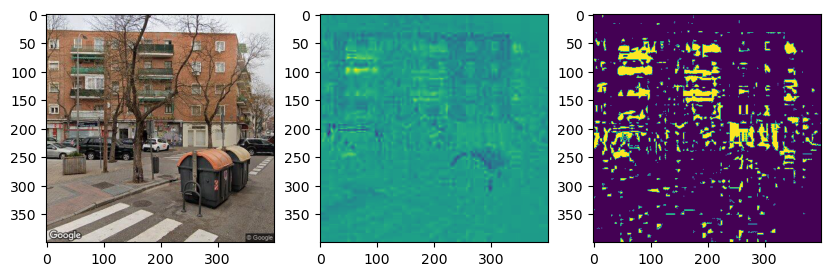

C:\Users\yougengl\AppData\Local\Temp\ipykernel_11256\2891427324.py:40: RuntimeWarning: invalid value encountered in true_divide
  sigma_b_squared = (mu_t*omega - mu)**2/(omega*(1-omega))
C:\Users\yougengl\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\yougengl\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The green view inde is 1.3875


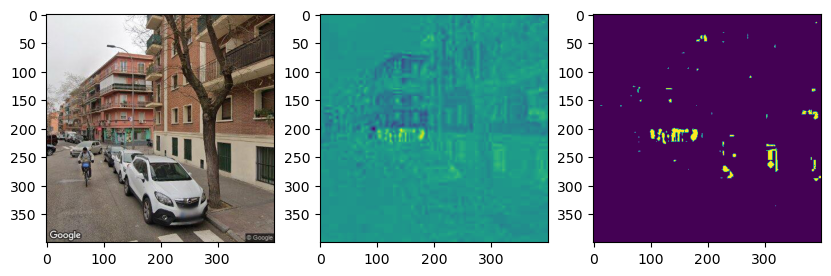

The green view inde is 28.450625000000002


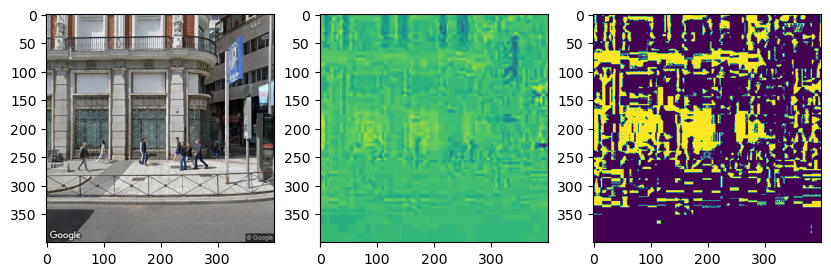

The green view inde is 18.607499999999998


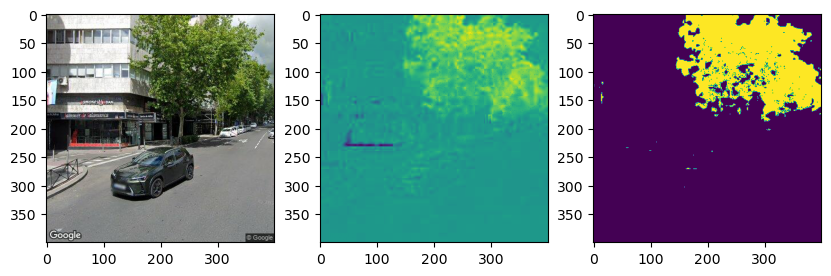

The green view inde is 29.988125


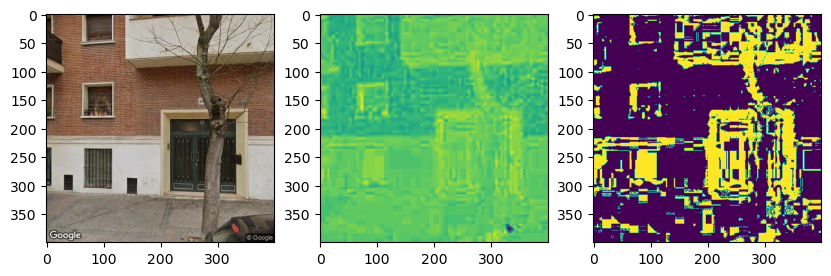

The green view inde is 21.174375


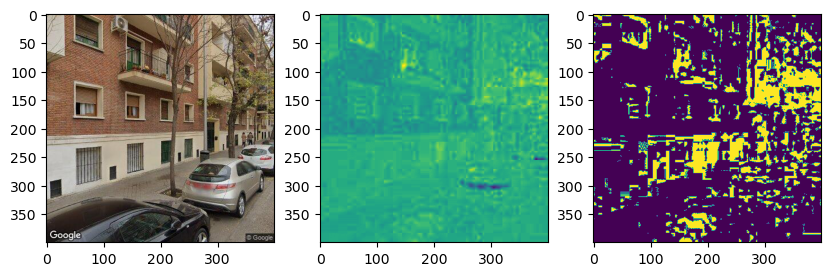

The green view inde is 17.130000000000003


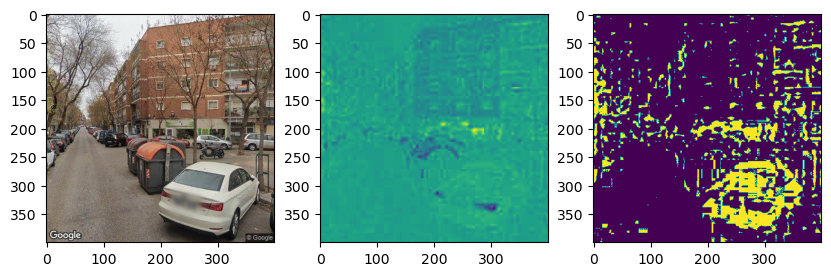

The green view inde is 13.35625


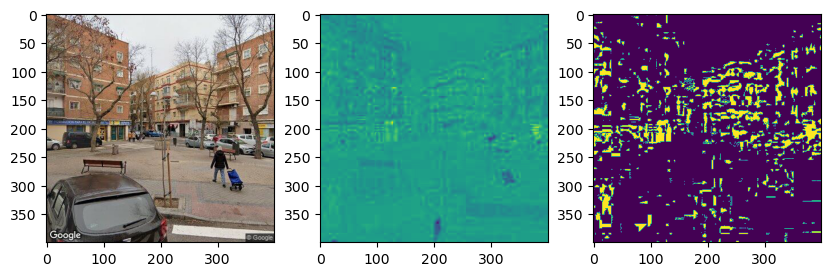

The green view inde is 7.885625


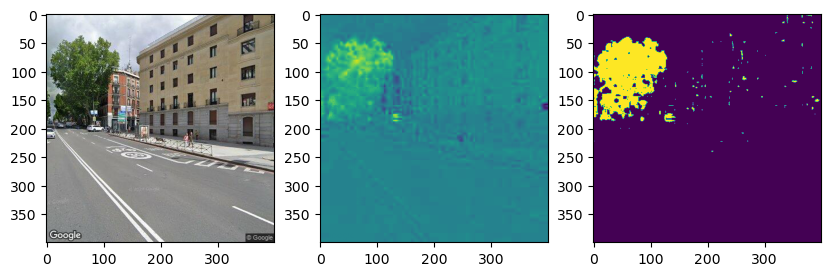

The green view inde is 30.290625


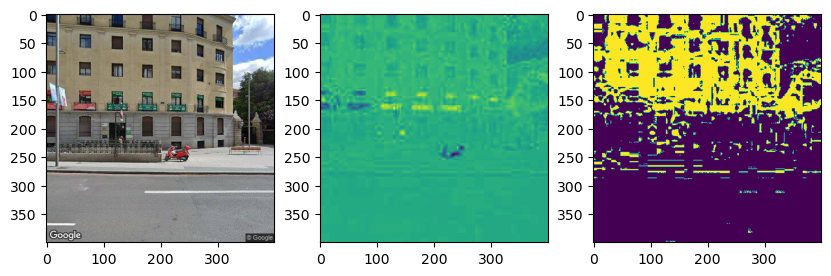

The green view inde is 20.22


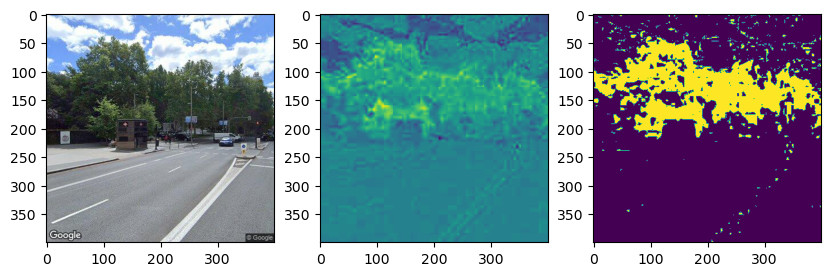

The green view inde is 7.9156249999999995


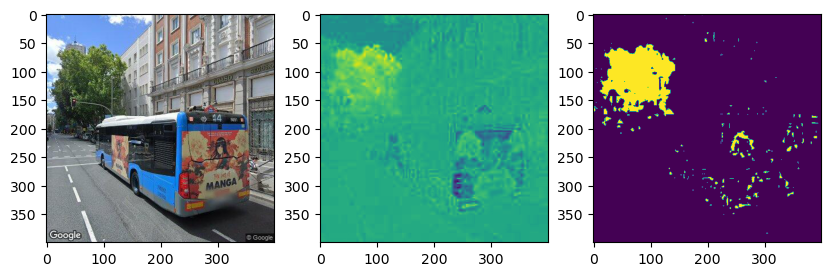

In [28]:
panoidlist = []
gsvimgs = 'D:/NatCap Research/Wellcome Trust/test'

for i, gsvfile in enumerate(os.listdir(gsvimgs)):
    elem = gsvfile.split('_')
    if len(elem) < 2: continue
    
    gsvfilename = os.path.join(gsvimgs,gsvfile)
    id = elem[1]
    
    if id not in panoidlist:
        panoidlist.append(id)
    
    
    im = np.array(Image.open(gsvfilename))
    I = im/255.0
    
    red = I[:,:,0]
    green = I[:,:,1]
    blue = I[:,:,2]
    
    # calculate the difference between green band with other two bands
    green_red_Diff = green - red
    green_blue_Diff = green - blue
    
    ExG = green_red_Diff + green_blue_Diff
    threshold = graythresh(ExG, 0.1)
    
    greenImg = ExG > threshold
    
    greenPxlNum = len(np.where(greenImg != 0)[0])
    greenPercent = greenPxlNum/(400.0*400)*100
    print('The green view index is', greenPercent)
    
    f = plt.figure(figsize=(10,10))
    f.add_subplot(1,3,1)
    plt.imshow(im)
    
    f.add_subplot(1,3,2)
    plt.imshow(ExG)
    
    f.add_subplot(1,3,3)
    plt.imshow(greenImg)
    plt.show()
    
    if i>10: break